In [37]:
import nibabel as nib
from nilearn import image, plotting
from nilearn.plotting import plot_roi
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import tempfile

In [38]:
# Paths to input T1-weighted image and pre-generated brain mask
t1w_mask_image_path = '/scratch1/sanskrut/outdir1/sub-032276_ses-001_run-1_T1w_pre_mask.nii.gz'

In [39]:
# Variables:

t1w_image_path = '/scratch1/sanskrut/site-lyon/sub-032276/ses-001/anat/sub-032276_ses-001_run-1_T1w.nii.gz'
model_path = '/scratch1/sanskrut/NHP-BrainExtraction/UNet_Model/models/Site-All-T-epoch_36.model'
output_dir = 'outdir1'
script_path = '/scratch1/sanskrut/NHP-BrainExtraction/UNet_Model/muSkullStrip.py'

In [40]:
# Execute skull stripping command with variables
skull_stripping_cmd = f"python3 {script_path} -in {t1w_image_path} -model {model_path} -out {output_dir}"
os.system(skull_stripping_cmd)

/home1/sanskrut/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


=============================Permforming Skullstripping=============================
sub-032276_ses-001_run-1_T1w.nii.gz


0

In [41]:
# Load the T1-weighted image and brain mask
t1w_image = nib.load(t1w_image_path)
brain_mask = nib.load(t1w_mask_image_path)

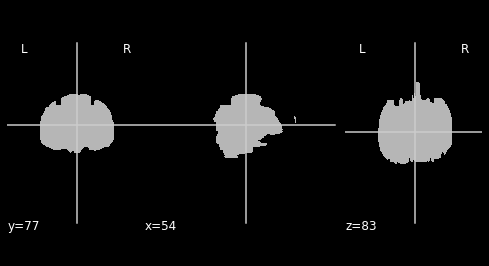

In [42]:
plotting.plot_anat(brain_mask)

In [43]:
# Apply the mask to the original T1-weighted image
masked_t1w_data = t1w_image.get_fdata() * brain_mask.get_fdata()
masked_t1w = nib.Nifti1Image(masked_t1w_data, t1w_image.affine)

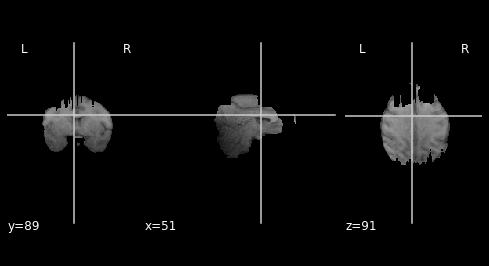

In [44]:
plotting.plot_anat(masked_t1w)

In [45]:
# Save masked T1-weighted image with only brain(outdir2)
subject_name = os.path.basename(t1w_image_path).split('_')[0]
masked_t1w_filename = f"{subject_name}.bse.nii.gz"
masked_t1w_path = os.path.join('outdir2', masked_t1w_filename)
nib.save(masked_t1w, masked_t1w_path)

In [46]:
# Save the brain mask
brain_mask_filename = f"{subject_name}.mask.nii.gz"
brain_mask_path = os.path.join('outdir3', brain_mask_filename)
nib.save(brain_mask, brain_mask_path)

In [49]:
# Perform N4 bias field correction
def n4_bias_field_correction(image_path):
    # Load the image
    img = nib.load(image_path)
    data = img.get_fdata()
    
    # Convert to SimpleITK image
    sitk_img = sitk.GetImageFromArray(data)
    
    # Create mask for N4 bias field correction
    mask = sitk.OtsuThreshold(sitk_img)
    
    # Perform N4 bias field correction
    corrected_img = sitk.N4BiasFieldCorrection(sitk_img, mask)
    
    # Convert back to numpy array
    corrected_data = sitk.GetArrayFromImage(corrected_img)
    
    # Save the corrected image
    subject_name = os.path.basename(image_path).split('_')[0]
    corrected_img_filename = f"{subject_name}.bfc.nii.gz"
    corrected_img_path = os.path.join('outdir4', corrected_img_filename)
    corrected_nib_img = nib.Nifti1Image(corrected_data, img.affine)
    nib.save(corrected_nib_img, corrected_img_path)
    
    return corrected_img_path

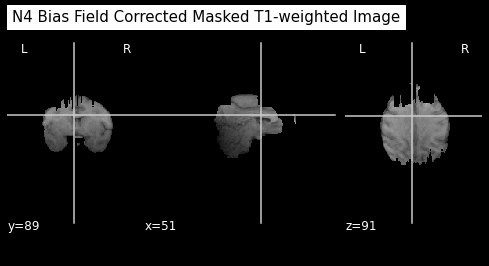

In [48]:
# Perform N4 bias field correction on masked T1-weighted image
corrected_masked_t1w_image_path = n4_bias_field_correction(masked_t1w_path)

# Load the corrected masked T1-weighted image
corrected_masked_t1w_image = nib.load(corrected_masked_t1w_image_path)

# Plot the corrected masked T1-weighted image
plotting.plot_anat(corrected_masked_t1w_image, title="N4 Bias Field Corrected Masked T1-weighted Image", display_mode='ortho')

# Display the plots
plt.show()